Class distribution before SMOTE: {1: 194, 0: 33}
SMOTE applied. New class distribution: {1: 194, 0: 194}
Class Weights (informational - SMOTE handles balance): {0: np.float64(1.0), 1: np.float64(1.0)}

MLPClassifier Model Summary (parameters):
MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32), max_iter=100,
              random_state=42, validation_fraction=0.2, verbose=True)

Training the MLPClassifier model...
Iteration 1, loss = 0.79529656
Validation score: 0.467742
Iteration 2, loss = 0.75758534
Validation score: 0.548387
Iteration 3, loss = 0.72596143
Validation score: 0.548387
Iteration 4, loss = 0.69652596
Validation score: 0.564516
Iteration 5, loss = 0.66905741
Validation score: 0.612903
Iteration 6, loss = 0.64525018
Validation score: 0.645161
Iteration 7, loss = 0.62208794
Validation score: 0.693548
Iteration 8, loss = 0.60217029
Validation score: 0.677419
Iteration 9, loss = 0.58398516
Validation score: 0.677419
Iteration 10, loss = 0.56782263
Validation score:

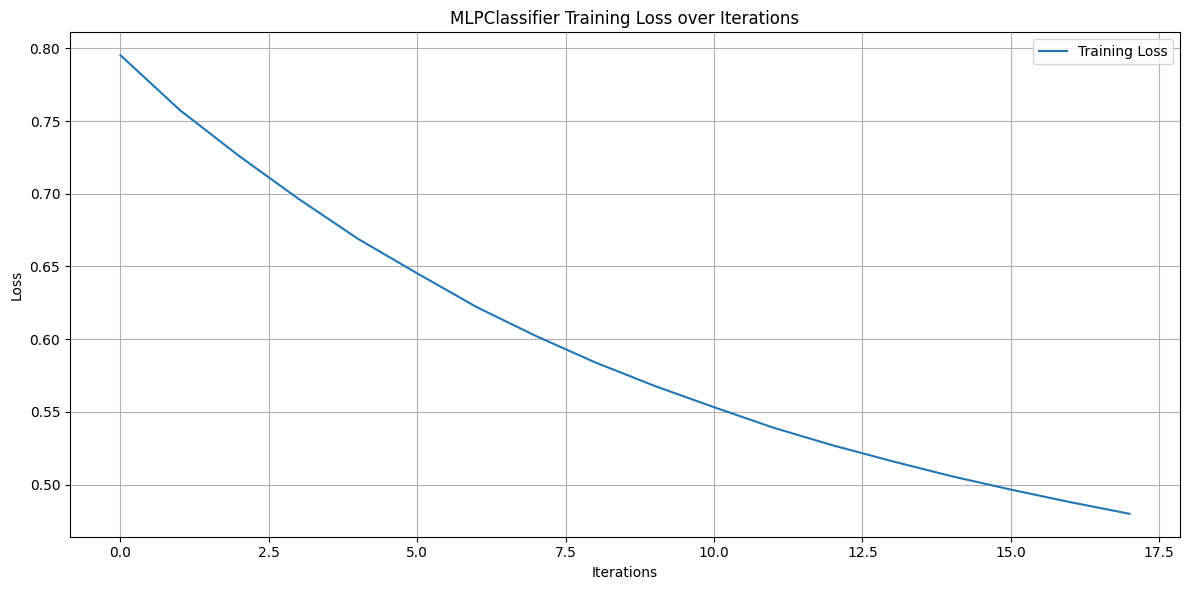

MLPClassifier model saved successfully as song_popularity_mlp_model.pkl
Scaler saved successfully as scaler.pkl


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier # Import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight # Still useful for analysis, but not directly used by MLPClassifier.fit()
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

# Step 1: Load the dataset
file_path = "/content/Spotify_data.csv"
if not os.path.exists(file_path):
    print(f"Error: Dataset not found at {file_path}. Please ensure the file is in the correct directory.")
    exit()

df = pd.read_csv(file_path)

# Step 2: Drop non-numeric columns
df = df.select_dtypes(include=[np.number])

# Step 3: Convert 'Popularity' into binary classes
y = (df['Popularity'] >= 65).astype(int)
X = df.drop('Popularity', axis=1)

# Step 4: Check distribution of classes
class_counts = y.value_counts()
print("Class distribution before SMOTE:", class_counts.to_dict())

# Step 5: Apply SMOTE for handling class imbalance if enough samples are present
if class_counts.min() >= 6:
    sm = SMOTE(random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)
    print("SMOTE applied. New class distribution:", pd.Series(y_sm).value_counts().to_dict())
else:
    print("Not enough samples for SMOTE (minority class has less than 6 samples). Using original data.")
    X_sm, y_sm = X, y

# Step 6: Train-test split
# Added stratify to ensure class distribution is similar in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm)

# Step 7: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Calculate class weights (for informational purposes, not directly used by MLPClassifier.fit)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights (informational - SMOTE handles balance):", class_weights_dict)

# Step 9: Build the MLPClassifier model
model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=100, # Corresponds to epochs
    random_state=42,
    verbose=True, # Set to True to see training progress
    early_stopping=True, # Enable early stopping
    validation_fraction=0.2, # Fraction of training data for validation during early stopping
    n_iter_no_change=10 # Stop if no improvement for 10 consecutive epochs
)

print("\nMLPClassifier Model Summary (parameters):")
print(model)

# Step 10: Train the model
print("\nTraining the MLPClassifier model...")
# Removed sample_weight argument as MLPClassifier.fit() does not support it
# The dataset is already balanced by SMOTE.
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# Step 11: Evaluate the model
y_pred = model.predict(X_test_scaled)

print("\n--- Model Evaluation Results ---")
print(f"MLPClassifier Binary Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 12: Plot training history (Loss Curve)
if hasattr(model, 'loss_curve_'):
    plt.figure(figsize=(12, 6))
    plt.plot(model.loss_curve_, label='Training Loss')
    plt.title('MLPClassifier Training Loss over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Loss curve not available for plotting.")

# Step 13: Save the trained model and scaler
try:
    joblib.dump(model, "song_popularity_mlp_model.pkl")
    print("MLPClassifier model saved successfully as song_popularity_mlp_model.pkl")
except Exception as e:
    print(f"Error saving model: {e}")

try:
    joblib.dump(scaler, "scaler.pkl")
    print("Scaler saved successfully as scaler.pkl")
except Exception as e:
    print(f"Error saving scaler: {e}")